In [5]:
from torchvision import transforms as T
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import struct
import numpy as np

main_dir = './emnist/'

class EmnistDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""
    def __init__(self, path, mode, selected=None, transform=None):
        """Load EMNIST data from `path`"""        
        self.transform = transform
        labels_path = os.path.join(path, 'emnist-letters-{}-labels-idx1-ubyte'.format(mode))
        images_path = os.path.join(path, 'emnist-letters-{}-images-idx3-ubyte'.format(mode))
        
        with open(labels_path, 'rb') as lbpath:
            magic, n = struct.unpack('>II', lbpath.read(8))
            self.labels = np.fromfile(lbpath, dtype=np.uint8)
            self.labels = self.labels.astype(np.int64)-1 # -1 to start from zero

        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            self.images = np.fromfile(imgpath, dtype=np.uint8).reshape(-1, 28, 28)
        
        if selected is not None:
            self.images = self.images[selected]
            self.labels = self.labels[selected]

        print(self.images.shape, self.labels.shape)

    def __getitem__(self, index):

        img = Image.fromarray(self.images[index].T)
        label = self.labels[index]
        
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.labels)

def get_loader(path, batch_size=32, mode='train', num_workers=1, selected=None, shuffle=None):
    """Build and return a data loader."""

    transform = []
    if mode == 'train':
        transform.append(T.RandomRotation(degrees=15, expand=False))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    dataset = EmnistDataset(path=path, mode=mode, transform=transform, selected=selected)
    
    if shuffle is None:
        shuffle = mode == 'train'
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers)
    
    return data_loader

def denorm(x):
    return x/2 + 0.5

(100000, 28, 28) (100000,)
(24800, 28, 28) (24800,)
(20800, 28, 28) (20800,)
torch.Size([128, 1, 28, 28]) torch.Size([128]) torch.int64


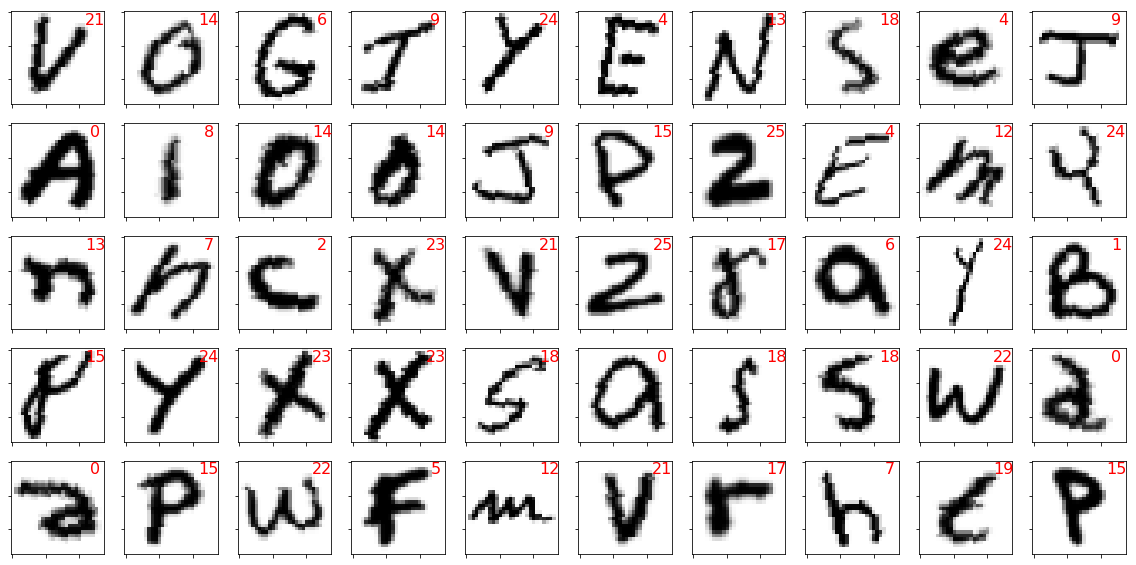

In [6]:
torch.manual_seed(0)

indxs = np.arange(124800)
train_indxs, valid_indxs = indxs[:100000], indxs[100000:]

train_loader = get_loader(path=main_dir, batch_size=128, selected=train_indxs, mode='train')
valid_loader = get_loader(path=main_dir, batch_size=128, selected=valid_indxs, mode='train')
test_loader = get_loader(path=main_dir, batch_size=128, mode='test')

batch_x, batch_y = next(iter(train_loader))

print(batch_x.shape, batch_y.shape, batch_y.dtype)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.imshow(denorm(batch_x[i, 0, :, :]).numpy(), cmap='binary')
    ax.text(0.9, 0.9, batch_y[i].item(), horizontalalignment='center', color='red', size=16,
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.show()

## ConvNet class

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ConvNet(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, conv_dim, n_classes=10):
        
        super(ConvNet, self).__init__()
        
        self.n_classes = n_classes
        self.final_dim = conv_dim*4 * 7*7

        self.main = nn.Sequential(
            nn.Conv2d(dim_in, conv_dim, kernel_size=5, stride=1, padding=2, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            nn.Dropout2d(p=0.2),
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(conv_dim*2, conv_dim*2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            
            nn.Dropout2d(p=0.2),
            nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(inplace=True),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.final_dim, 100),
            nn.LeakyReLU(),
            nn.Linear(100, n_classes))

    def forward(self, x, return_proba=False):
        x = self.main(x).view(-1, self.final_dim)
        logits = self.fc_layers(x)
        if not return_proba:
            return logits
        else:
            return torch.softmax(logits, dim=0)
    


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
import torch.optim as optim
import time
import datetime

class ElapsedTime():
    def __init__(self):
        self.start_time = time.time()
        
    def display(self, end=''):
        et = time.time() - self.start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        print("Elapsed [{}] ".format(et), end=end)

def train(model, train_loader, test_loader=None,
          device=None, num_epochs=10, learning_rate=0.01, log_iter=200):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model = model.to(device)
    #m = nn.LogSoftmax()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    
    et = ElapsedTime()
    for epoch in range(num_epochs):
        model.train()
        for i, (batch_x, batch_y) in enumerate(train_loader):
            data = batch_x.to(device)
            target = batch_y.to(device).view(-1)
            
            outputs = model(data, return_proba=False) #F.log_softmax(logits, dim=1)
            loss = criterion(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % log_iter == 0:
                print('Epoch {:02d}/{:02d} {:03d}/{:03d} | {:.4f}'.format(
                    epoch, num_epochs, i, len(train_loader), loss.item()))

        et.display(end='    ')
        if test_loader is not None:
            print('Epoch  {:2d}   Accuracy {:.2f}%'.format(
                    epoch, test(model, test_loader, device)*100))
        else:
            print()
            
                
####### Test function ###########
def test(model, test_loader, device):
    model = model.to(device)
    model.eval()
    
    n_tot, n_correct = 0, 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            data = batch_x.to(device)
            labels = batch_y.to(device)

            preds = model(data)
            n_correct += torch.sum(torch.argmax(preds, dim=1) == labels).item()
            n_tot += len(batch_x)
        
    return n_correct / n_tot

In [15]:
cnn = ConvNet(1, 64, 26)
train(cnn, train_loader, valid_loader, device=device, log_iter=250)
test(cnn, test_loader, device)

Epoch 00/10 000/782 | 3.2603
Epoch 00/10 250/782 | 0.8394
Epoch 00/10 500/782 | 0.6671
Epoch 00/10 750/782 | 0.4763
Elapsed [0:00:15]     Epoch   0   Accuracy 88.38%
Epoch 01/10 000/782 | 0.3709
Epoch 01/10 250/782 | 0.2770
Epoch 01/10 500/782 | 0.3174
Epoch 01/10 750/782 | 0.1741
Elapsed [0:00:35]     Epoch   1   Accuracy 91.45%
Epoch 02/10 000/782 | 0.2039
Epoch 02/10 250/782 | 0.2943
Epoch 02/10 500/782 | 0.2225
Epoch 02/10 750/782 | 0.2347
Elapsed [0:00:55]     Epoch   2   Accuracy 92.41%
Epoch 03/10 000/782 | 0.1329
Epoch 03/10 250/782 | 0.3219
Epoch 03/10 500/782 | 0.2489
Epoch 03/10 750/782 | 0.1095
Elapsed [0:01:16]     Epoch   3   Accuracy 92.92%
Epoch 04/10 000/782 | 0.1167
Epoch 04/10 250/782 | 0.1474
Epoch 04/10 500/782 | 0.1761
Epoch 04/10 750/782 | 0.2466
Elapsed [0:01:36]     Epoch   4   Accuracy 93.17%
Epoch 05/10 000/782 | 0.3493
Epoch 05/10 250/782 | 0.1095
Epoch 05/10 500/782 | 0.1164
Epoch 05/10 750/782 | 0.2267
Elapsed [0:01:55]     Epoch   5   Accuracy 93.13%
Epoc

0.9416346153846153